In [172]:
import os, sys
import pandas as pd, numpy as np, datetime as dt
import seaborn as sns
# create characteristic matrices
from characteristics import input_map
from fundamental_factors import base_fundamental_data_location
from characteristics import CharacterisitcMaker
import matplotlib.pyplot as plt
ROOT = './data/'
UNIVERSE = './data/universe.parquet'
BASE = './data/base_factors/'
RAW = './data/raw_factors/'
DERIVED = './data/derived_factors/'
TECHNICAL = './data/technical_factors/'
PROCESSED = './data/processed_factors/'
STANDARDIZED = './data/standardized_factors/'


In [140]:
uni = pd.read_parquet(UNIVERSE)
uni_monthly = uni.resample('M').last()
uni_monthly.to_parquet(f'{ROOT}universe_monthly.parquet')

In [155]:
def process_raw_data(uni_pd, d, t):
    """
    Processes raw data by handling missing values, infinite values, and standardizing the data.
    Parameters:
    d (pd.DataFrame): The raw data to be processed.
    t (str): A string identifier used for naming the output files.
    The function performs the following steps:
    1. Adds missing columns with default value 0.
    2. Reorders columns to match a predefined order (uni.columns).
    3. Replaces NaN values with 0.0.
    4. Replaces infinite values with 0.0.
    5. Saves the processed data to a parquet file.
    6. Standardizes the data by subtracting the mean and dividing by the standard deviation for each row.
    7. Saves the standardized data to a separate parquet file.
    Output files:
    - Processed data: saved as '{PROCESSED}{t}.parquet'
    - Standardized data: saved as '{STANDARDIZED}{t}.parquet'
    """
    missing_cols = set(uni_pd.columns) - set(d.columns)
    for col in missing_cols:
        d[col] = np.nan
    d = d[uni_pd.columns]
    # ensure that d is same structure as uni_pd
    if not (d.index.equals(uni_pd.index) and d.columns.equals(uni_pd.columns)):
        raise ValueError('[{t}] Input Data is not aligned with universe.')
    d.replace([np.inf, -np.inf], 0.0, inplace=True)
    
    # Standardize the data but only for values that are true in uni_pd
    standardized_d = (d[uni_pd] - d[uni_pd].mean(axis=1).values.reshape(-1, 1)) / d[uni_pd].std(axis=1).values.reshape(-1, 1)
    standardized_d = standardized_d.clip(lower=-3, upper=3, axis=1)
    standardized_d[standardized_d.isna()] = 0.0
    if not (standardized_d.index.equals(uni_pd.index) and standardized_d.columns.equals(uni_pd.columns)):
        raise ValueError('[{t}] Standardized Data is not aligned with universe.')
    standardized_d.to_parquet(f'{STANDARDIZED}{t}.parquet')

    d[d.isna()] = 0.0
    d.to_parquet(f'{PROCESSED}{t}.parquet')
    

In [160]:
def process_files(directory):
    """
    Processes files in the given directory by filtering out files that contain '_Q' in their names,
    and then processes the remaining files.
    Args:
        directory (str): The path to the directory containing the files to be processed.
    Returns:
        None
    This function performs the following steps:
    1. Lists all files in the specified directory.
    2. Filters out files that contain '_Q' in their names and removes the '.parquet' extension from the remaining files.
    3. For each filtered file, reads the corresponding parquet file and processes the raw data using the `process_raw_data` function.
    """
    all_files = os.listdir(directory)
    all_files = [file for file in all_files if file != '.DS_Store']
    filtered_files = [file.replace('.parquet', '') for file in all_files if '_Q' not in file]
    if directory.strip('/').split('/')[-1] == RAW.strip('/').split('/')[-1]:
        # raw factors has some base factors that needs to be renamed and copied to base factors
        raw_to_base = {
            'netIncome':'NI',
            'bookValuePerShare':'BVPS',
            'revenuePerShare':'RPS',
            'stockPrice':'SP',
            'depreciationAndAmortization':'DA',
            'tangibleAssetValue':'TAV',
            'totalAssets':'TA',
            'totalDebt':'TD',
            'longTermDebt':'LTD',
            'netIncomePerShare':'NIPS',
            'numberOfShares':'NS',
            'totalStockholdersEquity':'TSE'
        }
        for t in filtered_files:
            print(f'[{t}] Processing')
            raw = pd.read_parquet(f'{directory}{t}.parquet')
            if t in raw_to_base.keys():                
                t = raw_to_base[t]
                print(f'[{t}] Copying to Base factors')
                raw.to_parquet(f'{BASE}{t}.parquet')        
                process_raw_data(uni_monthly, raw, t)
            else:
                continue
        
    else:
        for t in filtered_files:
            print(f'[{t}] Processing')
            raw = pd.read_parquet(f'{directory}{t}.parquet')
            process_raw_data(uni_monthly, raw, t)

process_files(RAW)
process_files(DERIVED)
process_files(TECHNICAL)

    

[returnOnTangibleAssets] Processing
[netIncome] Processing
[NI] Copying to Base factors
[operatingCashFlow] Processing
[dividendYield] Processing
[bookValuePerShare] Processing
[BVPS] Copying to Base factors
[revenuePerShare] Processing
[RPS] Copying to Base factors
[totalDebt] Processing
[TD] Copying to Base factors
[stockPrice] Processing
[SP] Copying to Base factors
[cashAtEndOfPeriod] Processing
[totalAssets] Processing
[TA] Copying to Base factors
[changeInWorkingCapital] Processing
[depreciationAndAmortization] Processing
[DA] Copying to Base factors
[debtToEquity] Processing
[numberOfShares] Processing
[NS] Copying to Base factors
[operatingCashFlowPerShare] Processing
[researchAndDdevelopementToRevenue] Processing
[tangibleAssetValue] Processing
[TAV] Copying to Base factors
[taxPayables] Processing
[longTermDebt] Processing
[LTD] Copying to Base factors
[totalStockholdersEquity] Processing
[TSE] Copying to Base factors
[earningsYield] Processing
[priceToSalesRatio] Processing


In [176]:
def merge_data(directory):
    """
    Merges data from the specified directory into a single DataFrame.
    Args:
        directory (str): The path to the directory containing the data files to be merged.
    Returns:
        pd.DataFrame: The merged DataFrame containing data from all files in the specified directory.
    This function performs the following steps:
    1. Lists all files in the specified directory.
    2. Reads each file and concatenates the data into a single DataFrame.
    3. Returns the merged DataFrame.
    """
    all_files = os.listdir(directory)
    all_files = [file for file in all_files if file != '.DS_Store']
    all_files.sort()
    data_frames = []
    char_list = []
    merged_file_name = directory.strip('/').split('/')[-1]

    for file in all_files:
        df = pd.read_parquet(f'{directory}{file}')
        if df.shape != (342, 2941):
            print("SKIPPING file = {}, incorrect shape = {}".format(file, df.shape))
            continue
        df.columns = [f"{file}_{col}" for col in df.columns]  # Add prefix to column names
        print(f'File: {file}, Shape: {df.shape}')
        data_frames.append(df)
        char_list.append(file.split('.')[0])
    data = pd.concat(data_frames, axis=1)
    data.to_parquet(f'{ROOT}{merged_file_name}_MERGED.parquet')
    data.to_csv(f'{ROOT}{merged_file_name}_MERGED.txt', header=False, index=False, sep='\t')
    with open(f'{ROOT}{merged_file_name}_char_list.txt', 'w') as f:
        for item in char_list:
            f.write("%s\n" % item)

merge_data(PROCESSED)
merge_data(STANDARDIZED)

File: ACC.parquet, Shape: (342, 2941)
File: ATO.parquet, Shape: (342, 2941)
File: BETA.parquet, Shape: (342, 2941)
File: BM.parquet, Shape: (342, 2941)
File: BVPS.parquet, Shape: (342, 2941)
File: CASH.parquet, Shape: (342, 2941)
File: CASHDEBT.parquet, Shape: (342, 2941)
File: CFP.parquet, Shape: (342, 2941)
File: CHCSHO.parquet, Shape: (342, 2941)
File: CHPM.parquet, Shape: (342, 2941)
File: DA.parquet, Shape: (342, 2941)
File: DEPR.parquet, Shape: (342, 2941)
File: DOLVOL.parquet, Shape: (342, 2941)
File: DY.parquet, Shape: (342, 2941)
File: EP.parquet, Shape: (342, 2941)
File: GRLTNOA.parquet, Shape: (342, 2941)
File: LGR.parquet, Shape: (342, 2941)
File: LTD.parquet, Shape: (342, 2941)
File: Leverage.parquet, Shape: (342, 2941)
File: ME.parquet, Shape: (342, 2941)
File: MOM12M.parquet, Shape: (342, 2941)
File: MOM36M.parquet, Shape: (342, 2941)
File: MOM60M.parquet, Shape: (342, 2941)
File: MOM6M.parquet, Shape: (342, 2941)
File: MOM_1M.parquet, Shape: (342, 2941)
File: NI.parquet

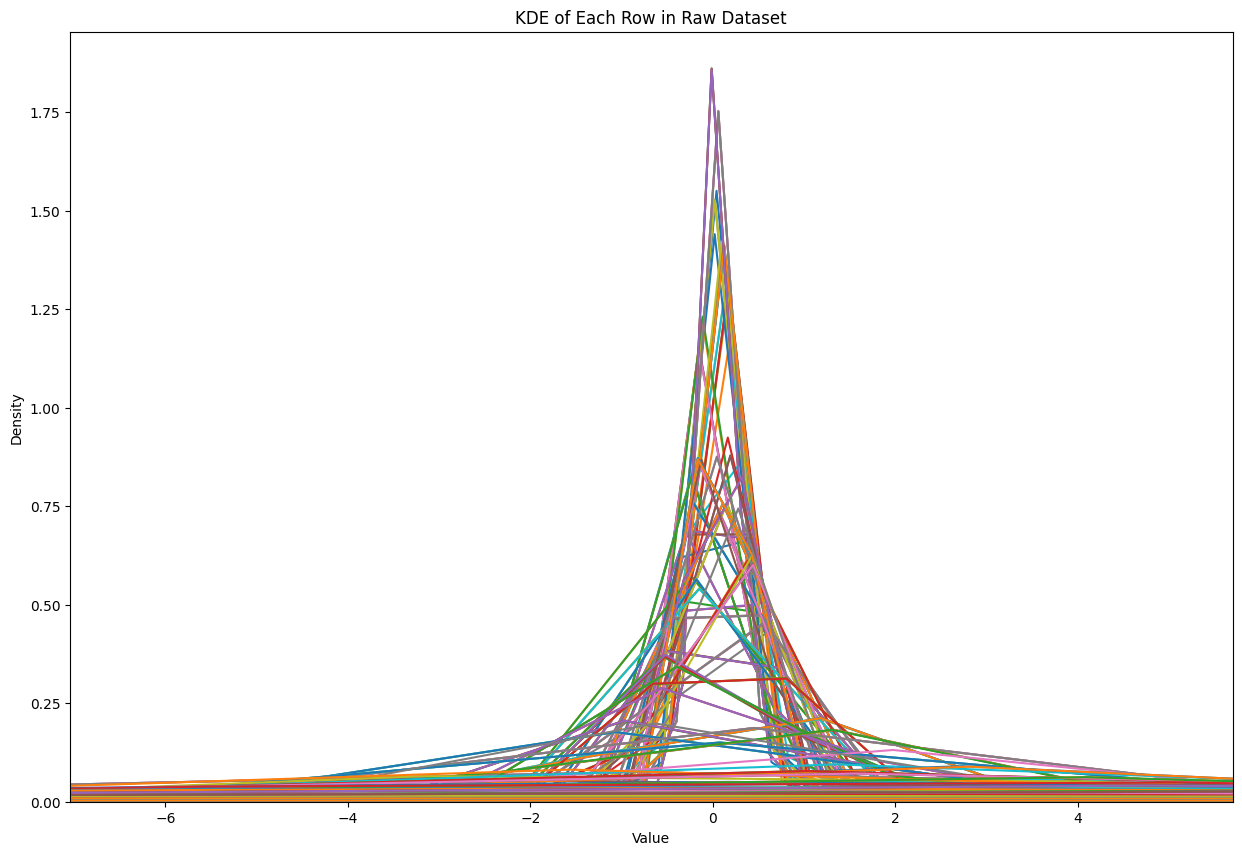

In [169]:
raw = pd.read_parquet('./data/processed_factors/NIPS.parquet')
overall_percentiles = raw.values.flatten()
overall_percentiles = np.percentile(overall_percentiles, [1, 99])

# Calculate and plot the KDE for each row in the raw dataset
plt.figure(figsize=(15, 10))

for index, row in raw.iterrows():
# for index, row in raw.tail(5).iterrows():
    sns.kdeplot(row, label=index, bw_adjust=0.5)
    plt.xlim(overall_percentiles[0], overall_percentiles[1])

plt.legend([],[], frameon=False)
plt.title('KDE of Each Row in Raw Dataset')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

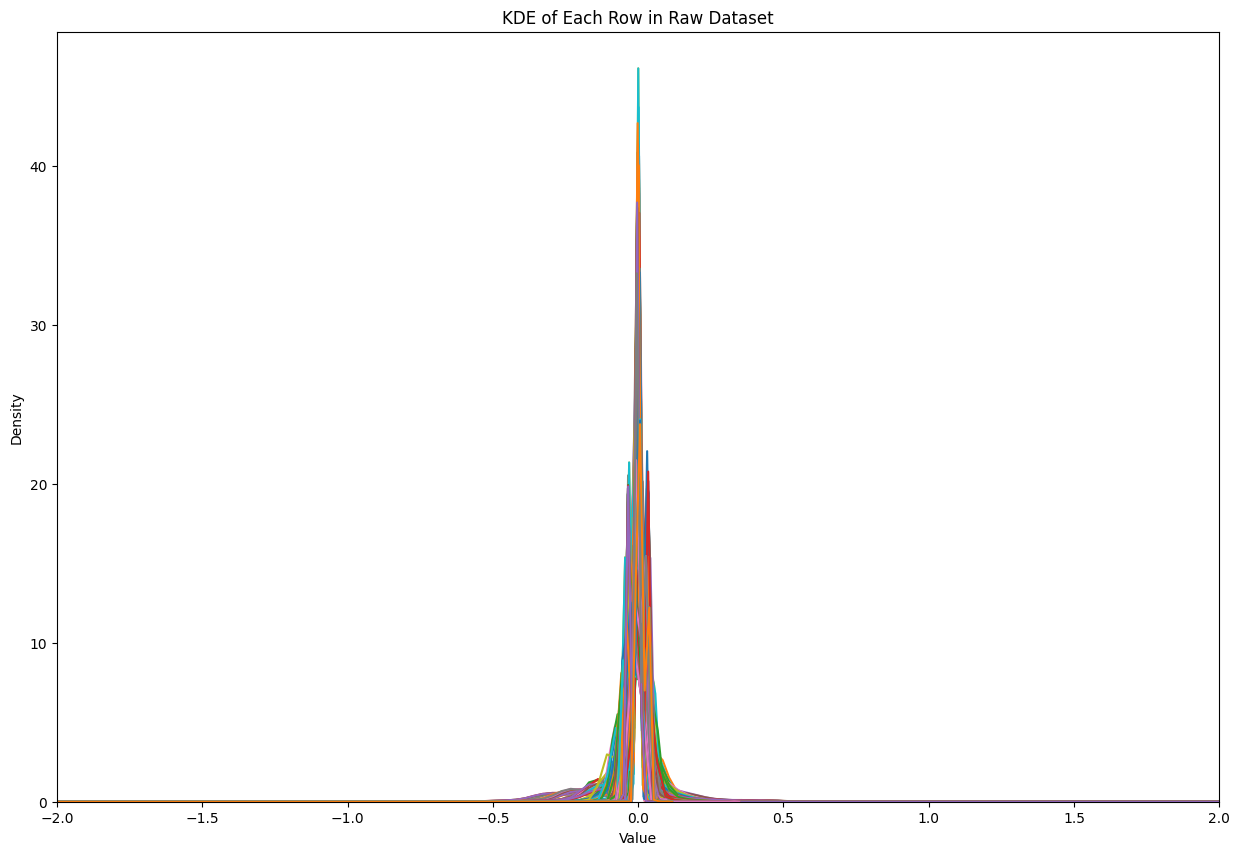

In [ ]:
# standardized_raw = (raw - raw.mean(axis=1).values.reshape(-1, 1)) / raw.std(axis=1).values.reshape(-1, 1)
standardized_raw = pd.read_parquet('./data/standardized_factors/NIPS.parquet')
# overall_percentiles = standardized_raw.values.flatten()
#overall_percentiles = np.percentile(overall_percentiles, [1, 99])

# Calculate and plot the KDE for each row in the raw dataset
plt.figure(figsize=(15, 10))

# for index, row in standardized_raw.tail(5).iterrows():
for index, row in standardized_raw.iterrows():
    sns.kdeplot(row, label=index, bw_adjust=0.5)
    plt.xlim(-2,2)

plt.legend([],[], frameon=False)
plt.title('KDE of Each Row in Raw Dataset')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()